In [1]:
%matplotlib inline
import pandas as pd 
import statsmodels.api as sm
import sklearn
from sklearn import linear_model
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import scipy
#initial data
filepath_town_state=str(r'C:\Users\Kalinin\Desktop\kaggle\town_state.csv')
filepath_train=str(r'C:\Users\Kalinin\Desktop\kaggle\train.csv') #74180464 rows
#read town_state.csv
town_state_data = pd.read_csv(filepath_town_state)
#read part from the huge train.csv
file = (open(filepath_train, 'r'))
i = 0
traindata=[]
for line in file:
    if i%50==0:
        traindata.append(line.rstrip().split(','))
    i+=1
traindata = pd.DataFrame(traindata[1:], dtype='int', columns=traindata[0])
traindata = traindata[['Demanda_uni_equil', 'Agencia_ID', 'Canal_ID', 'Semana']]
#merge two tables by Agencia_ID (Sales Depot ID)
#we have 790 unique Agencia_ID and only 259 towns and 33 states
traindata=pd.merge(traindata, town_state_data, on='Agencia_ID', how='inner')
#create names instead of ID's of Canals (Sales Channel) (for comfortable dummies)
traindata['Canal_ID'] = 'Sales Channel id (' + traindata['Canal_ID'].astype(str) + ')'

Решение задачи Grupo Bimbo по прогнозированию спроса (расчетная величина, большая или равная нулю, выраженная как разница между купленным и возвращенным товаром) позволит оценить выручку компании в краткосрочном периоде, с целью более эффективного оперирования затратами, оптимизации текущей деятельности и ресурсов. Значимость решения подобных задач измеряется снижением затрат и приростом дохода относительно периодов без использования какой-либо модели прогнозирования.
  
В задаче имеем следующие данные (выделены названия столбцов, присутствующие в файле test.csv, т.е. известные, по идее, компании заранее, и опираясь на которые прогнозисту необходимо построить адекватную модель для предсказания Y):
- **Semana**. Номер недели
- **Agencia_ID**. id склада (по этому id подтягиваются город и штат склада)
- **Canal_ID**. id канала продаж
- **Ruta_SAK**. id маршрута продаж (у одного склада несколько маршрутов)
- ** Cliente_ID**. id клиента (по этому id подтягиваются имена клиентов)
- **Producto_ID**. id продукта (по этому id подтягиваются наименования продуктов)
- Venta_uni_hoy. Количество проданных товаров на неделе
- Venta_hoy. Выручка от проданных товаров на неделе
- Dev_uni_proxima. Количество возвращенных товаров на неделе
- Dev_proxima. Недополученная выручка от возвращенных товаров на неделе
- Demanda_uni_equil. Y. Спрос. Определяется как количество проданного товара минус количество возвращенного товара

Несколько слов по поводу данных. Нет понимания, чем является id канала продаж. Однако для построения модели каналы продаж являются категориальными переменными и знание, какому каналу (например, онлайн-продажи или, может, курьерская доставка, самовывоз) в действительности соответствует какой id, ключевой роли, на мой взгляд, не играет, как и знание имен клиентов и городов их проживания, которые можно подчерпнуть из искомой базы данных.
  
Несмотря на то, что обучающая выборка содержит данные всего за 7 недель, можно попробовать включить продажи прошлой/позапрошлой недели как лаговую переменную в уравнение.

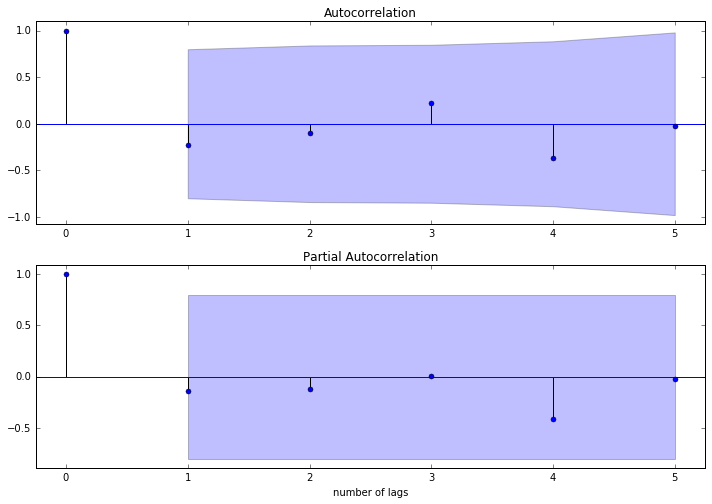

In [2]:
#acf/pacf
mu = traindata.groupby(['Semana']).mean()
acf = sm.tsa.stattools.acf(mu.Demanda_uni_equil, nlags=5)
pacf = sm.tsa.stattools.pacf(mu.Demanda_uni_equil, nlags=5, method='ols')
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(acf, lags=5, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pacf, lags=5, ax=ax2)
plt.xlabel('number of lags')
plt.show()

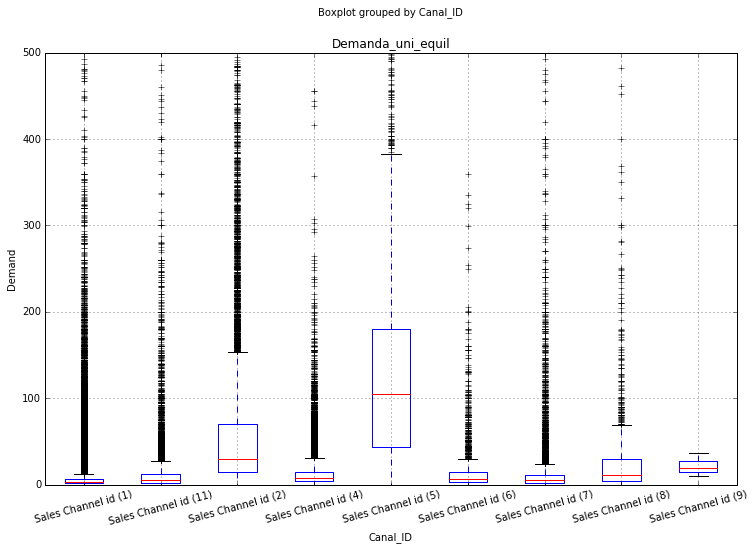

In [3]:
#other graphics
ax1=traindata.boxplot(column='Demanda_uni_equil', by='Canal_ID', rot=15, figsize=(12,8))
ax1.set_ylim(0,500)
plt.ylabel('Demand')
plt.show()

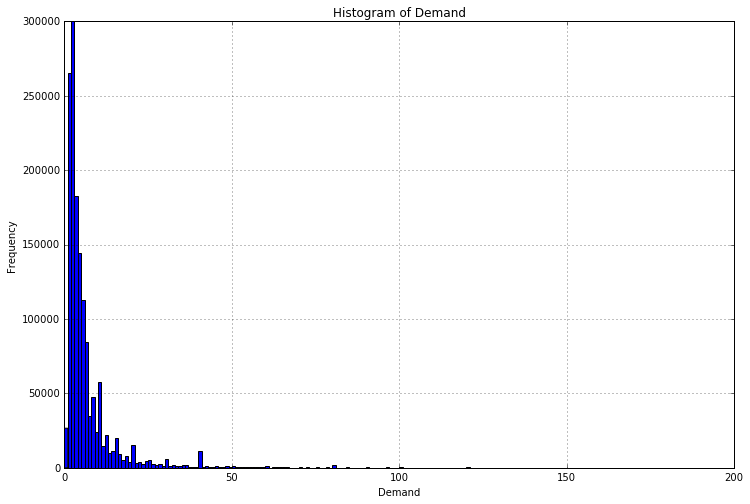

In [4]:
traindata['Demanda_uni_equil'].hist(bins=200, range=(0,200), figsize=(12,8))
plt.xlabel('Demand')
plt.ylabel('Frequency')
plt.title('Histogram of Demand')
plt.show()

Но, как видно из графиков АКФ и ЧАКФ, нет ни одного значимого фактора номера недели с уровнем лага до 5. Гораздо эффективнее с точки зрения прогнозирования было бы иметь данные по дням за период в полгода/год (отсутствие подобной информации фактически закрывает возможность использовать класс моделей временных рядов, несмотря на то, что сами данные являются распределенными во времени и могут иметь сезонность, тренд и т.п.).
  
Отсутствует информация по соц-дем профилю клиентов и также по категориям/типам продуктов, что не позволяет собрать в группы эти данные и использовать их в качестве фиктивных переменных. В текущем, неагрегированном виде, количество уникальных имен и продуктов чрезвычайно велико и нет возможности добавить их все как фиктивные переменные вследствие ограниченной мощности компьютера. Во-вторых, с учетом того, что именно эти данные в наибольшей степени подвержены изменению, добавлению новых значений (появление клиентов, дополнительных продуктов и т.п.) и, не зная их «классы» наперед (например, какая-то платежеспособная молодая аудитория или ходовой тип товара), коэффициенты модели пришлось бы пересчитывать каждый раз заново.
  
Несомненным плюсом доступных данных является наличие информации о штате, в котором расположен склад, и типе канала продаж – эти данные и будем использовать для прогноза.
  
Сравнивать модели по таким показателям, как F-статистика, нельзя в связи с различной структурой самих моделей. Также в первую очередь важно не столько качество «подгонки» моделируемой функции под Y, сколько прогностическая пригодность итоговой модели. Для сравнения используется показатель MSE (Mean squared error; сумма квадратов разностей между фактическим значением спроса и прогнозным), так как, во-первых, подобная статистика накладывает «штраф» на большие отклонения, во-вторых, нет вероятности получить ноль, если различные по знаку отклонения компенсируют друг друга (в случае суммы простых отклонений). Также рассчитывается MAPE (mean absolute percentage error; сумма модулей разности между фактическим и прогнозным значениями, деленным на фактическое значение) для понимания процентного отклонения. И дополнительно RMSLE (эта оценка стоит в условиях самого соревнования). Также можно было использовать такие статистики, как R2 adj. или AIC.
  
Далее результаты МНК по Canal_ID  и State, выраженных как фиктивные переменные.

In [5]:
#create dummy variables
traindata = traindata.join(pd.get_dummies(traindata['Canal_ID']))
traindata = traindata.join(pd.get_dummies(traindata['State']))
#print(traindata.count())

#create lists of independent/dependent variables
dependent_variable = ['Demanda_uni_equil']
independent_variables = traindata['Canal_ID'].unique()
variable_remove = independent_variables[0]
independent_variables = independent_variables.tolist()
independent_variables_OLS = list(independent_variables)
independent_variables_OLS.remove(variable_remove)
independent_variables_SGD = list(independent_variables)
independent_variables = traindata['State'].unique()
variable_remove = independent_variables[0]
independent_variables = independent_variables.tolist()
independent_variables_OLS.extend(list(independent_variables))
independent_variables_OLS.remove(variable_remove)
independent_variables_SGD.extend(list(independent_variables))
traindata.drop(['Agencia_ID', 'Canal_ID', 'Town', 'State'], axis=1, inplace=True)
traindata['Intercept'] = 1 #add constant for OLS model
independent_variables_OLS.extend(['Intercept'])
#independent_variables_SGD.extend(['Intercept'])

#forecast
size = round(traindata['Demanda_uni_equil'].count()*0.75, 0).astype(int)
OLS_data = sm.OLS(traindata[dependent_variable][0:size], traindata[independent_variables_OLS][0:size], missing='drop')
result = OLS_data.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      Demanda_uni_equil   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     5840.
Date:                Sat, 06 Aug 2016   Prob (F-statistic):               0.00
Time:                        22:12:04   Log-Likelihood:            -4.8922e+06
No. Observations:             1112707   AIC:                         9.785e+06
Df Residuals:                 1112672   BIC:                         9.785e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Sales Channel id (8)     28.42

Как видно из результатов расчета МНК-регрессии, многие переменные не значимы (p-value>0.05), однако не были исключены из итогового уравнения по той причине, что при использовании модели в будущем они могут снова встретится. Несколько незначимых переменных можно выделить в столбец (например, «Other state»), однако подобное объединение требует дополнительного анализа причин высокого p-value, и обоснованности такого объединения. Также, во-первых, F-статистика регрессии статистически значима, а на больших данных значение p-value для незначимых сейчас переменных может измениться.

In [6]:
SGD_data = sklearn.linear_model.SGDRegressor(alpha=0.01, n_iter=np.ceil(10**6/size), loss='squared_loss', shuffle=True, verbose=0)
SGD_data.fit(traindata[independent_variables_SGD][0:size], traindata[dependent_variable][0:size].values.ravel())

SGDRegressor(alpha=0.01, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=1.0, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

В качестве ML-решения был выбран алгоритм SGD (Stochastic Gradient Descent) для подгонки линейных моделей. Минимизируется функция суммы квадратов разницы между фактическим значениям и выходным. Корректировка весов происходит отдельно для каждого значения из обучающей выборки, что является отличием от обычного алгоритма градиентного спуска (корректирующего веса w только по окончании эпохи) и преимуществом, т.к. позволяет уменьшить количество итераций прохождения через всю выборку и время на обучение. Алгоритм «стохастический» потому что на каждой эпохе данные из обучающей выборки подаются на вход в случайном порядке и оптимизация происходит в случайном направлении, приходя каждый раз в иной оптимум. Различие результатов в алгоритме GD может зависеть только от выбора начальных значений матрицы весов.Также логика SGD подразумевает, что в обучающей выборке могут находиться редкие значения, дающие для вектора градиента и поиска минимума больше информации, чем «средняя» всей выборки в случае GD. Однако алгоритм SGD не так устойчив к локальным минимумам, как обычный GD. Как компромисс между GD и SGD можно было бы использовать Mini-Batch Gradient Descent, использующий для единовременной корректировки весов не 1 значение (SGD) или всю выборку (GD), но небольшие выборки из обучающего массива данных.

residuals_OLS:
Ttest_1sampResult(statistic=9.9426664560232704e-10, pvalue=0.99999999920669014)
residuals_SGD:
Ttest_1sampResult(statistic=8.2097937435424182, pvalue=2.2180170339068063e-16)


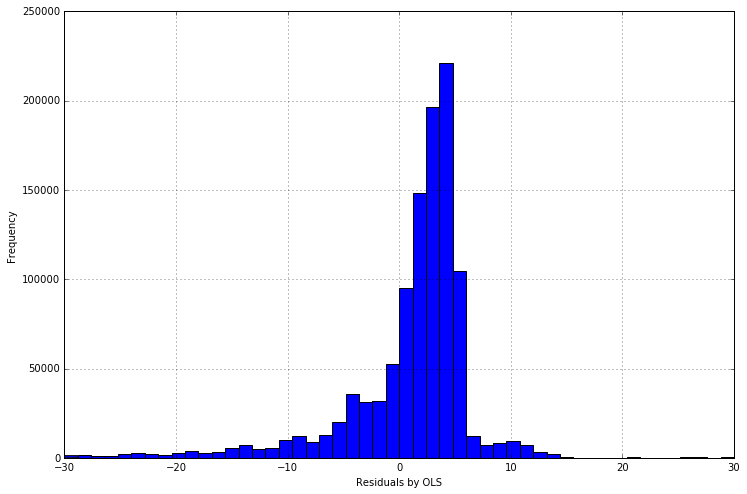

In [7]:
#residuals mean
residuals_OLS = result.predict(traindata[independent_variables_OLS][0:size])-traindata['Demanda_uni_equil'][0:size]
residuals_SGD = SGD_data.predict(traindata[independent_variables_SGD][0:size])-traindata['Demanda_uni_equil'][0:size]
print('residuals_OLS:')
print(scipy.stats.ttest_1samp(residuals_OLS, 0))
print('residuals_SGD:')
print(scipy.stats.ttest_1samp(residuals_SGD, 0))
residuals_OLS.hist(bins=50, range=(-30,30), figsize=(12,8))
plt.ylabel('Frequency')
plt.xlabel('Residuals by OLS')
plt.show()

Здесь видно, что мат. ожидание остатков МНК статистически значимо не отличается от нуля (в отличие от SGD). На остальные условия Гаусса-Маркова модель проверена не была.

In [8]:
#create dataframe for prediction
traindata_predict=pd.DataFrame(traindata[size:], columns=traindata.columns)
datazie=traindata_predict['Demanda_uni_equil'].count()

#predict by OLS
traindata_predict['Predict_OLS'] = result.predict(traindata_predict[independent_variables_OLS])
MSE_OLS = sum((traindata_predict['Demanda_uni_equil']-traindata_predict['Predict_OLS'])**2)/datazie
print('MSE_OLS: ' + str(MSE_OLS))
RMSLE_OLS = np.sqrt(sum((np.log(traindata_predict['Predict_OLS']+1)-np.log(traindata_predict['Demanda_uni_equil']+1))**2)/datazie)
print('RMSLE_OLS: ' + str(RMSLE_OLS))
MAPE_OLS = sum((np.fabs(traindata_predict['Demanda_uni_equil']-traindata_predict['Predict_OLS'])/traindata_predict['Demanda_uni_equil']).replace([np.inf, -np.inf], 0))/datazie
print('MAPE_OLS: ' + str(MAPE_OLS))

#predict by mean
Predict_mean = sum(traindata_predict['Demanda_uni_equil'])/datazie
MSE_mean = sum((traindata_predict['Demanda_uni_equil']-Predict_mean)**2)/datazie
print('MSE_mean: ' + str(MSE_mean))
RMSLE_mean = np.sqrt(sum((np.log(Predict_mean+1)-np.log(traindata_predict['Demanda_uni_equil']+1))**2)/datazie)
print('RMSLE_mean: ' + str(RMSLE_mean))
MAPE_mean = sum((np.fabs(traindata_predict['Demanda_uni_equil']-Predict_mean)/traindata_predict['Demanda_uni_equil']).replace([np.inf, -np.inf], 0))/datazie
print('MAPE_mean: ' + str(MAPE_mean))

#predict by SGD
traindata_predict['Predict_SGD'] = SGD_data.predict(traindata_predict[independent_variables_SGD])
MSE_SGD = sum((traindata_predict['Demanda_uni_equil']-traindata_predict['Predict_SGD'])**2)/datazie
print('MSE_SGD: ' + str(MSE_SGD))
RMSLE_SGD = np.sqrt(sum((np.log(traindata_predict['Predict_SGD']+1)-np.log(traindata_predict['Demanda_uni_equil']+1))**2)/datazie)
print('RMSLE_SGD: ' + str(RMSLE_SGD))
MAPE_SGD = sum((np.fabs(traindata_predict['Demanda_uni_equil']-traindata_predict['Predict_SGD'])/traindata_predict['Demanda_uni_equil']).replace([np.inf, -np.inf], 0))/datazie
print('MAPE_SGD: ' + str(MAPE_SGD))

MSE_OLS: 548.916424726
RMSLE_OLS: 0.894184765592
MAPE_OLS: 1.69741495568
MSE_mean: 640.566105234
RMSLE_mean: 1.01296097562
MAPE_mean: 2.19251421356
MSE_SGD: 574.307971656
RMSLE_SGD: 0.905486159506
MAPE_SGD: 1.75904624324


Как видно, оценивая результаты прогноза моделей по RMSLE, SGD значительно превосходит показатели обычного среднего, используемого в качестве прогноза, и немного хуже показателя уравнения, рассчитанного МНК.